## Demand data model

In [1]:
import pandas as pd
demand_df = pd.read_csv("..\Data\demand_prices\demand_data_2009_2025.csv", compression='gzip')
display(demand_df)
demand_df.info()

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293753,2025-10-03,44,25095,26540,23271,5343,6606,0,20993,0,319,507,580,409,231,0,-626
293754,2025-10-03,45,23308,24743,21619,5268,6606,0,20993,0,433,-3,-245,443,135,0,-254
293755,2025-10-03,46,22176,23499,20725,5192,6606,0,20993,0,226,-50,-321,435,99,0,-226
293756,2025-10-03,47,20740,22457,19448,5271,6606,0,20993,0,87,-234,-220,-325,38,-11,179


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293758 entries, 0 to 293757
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   settlement_date            293758 non-null  object
 1   settlement_period          293758 non-null  int64 
 2   nd                         293758 non-null  int64 
 3   tsd                        293758 non-null  int64 
 4   england_wales_demand       293758 non-null  int64 
 5   embedded_wind_generation   293758 non-null  int64 
 6   embedded_wind_capacity     293758 non-null  int64 
 7   embedded_solar_generation  293758 non-null  int64 
 8   embedded_solar_capacity    293758 non-null  int64 
 9   non_bm_stor                293758 non-null  int64 
 10  pump_storage_pumping       293758 non-null  int64 
 11  ifa_flow                   293758 non-null  int64 
 12  ifa2_flow                  293758 non-null  int64 
 13  britned_flow               293758 non-null  

In [ ]:
# 0. libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# assume demand_df already loaded and settlement_date is datetime
df = demand_df.copy()
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df = df.sort_values('settlement_date').reset_index(drop=True)

# 1. Feature engineering (lags + rolling)
def make_features(df, lags=[1,48,336], rolls=[3,6,24,48]):
    df2 = df.copy()
    # time features
    df2['hour'] = df2['settlement_date'].dt.hour
    df2['dayofweek'] = df2['settlement_date'].dt.dayofweek
    df2['month'] = df2['settlement_date'].dt.month
    df2['is_weekend'] = df2['dayofweek'].isin([5,6]).astype(int)

    # lag features
    for l in lags:
        df2[f'nd_lag_{l}'] = df2['nd'].shift(l)

    # rolling means/std
    for r in rolls:
        df2[f'nd_roll_mean_{r}'] = df2['nd'].shift(1).rolling(r).mean()
        df2[f'nd_roll_std_{r}']  = df2['nd'].shift(1).rolling(r).std()

    # fill or leave NaNs (we use drop for simplicity)
    return df2

df_feat = make_features(df)
df_feat = df_feat.dropna().reset_index(drop=True)  # keep only rows with complete features

# 2. Train/test split (time-aware)
train_frac = 0.8
n = len(df_feat)
train_idx = int(n * train_frac)
train = df_feat.iloc[:train_idx]
test  = df_feat.iloc[train_idx:]

# 3. Use PyCaret regression (autoML)
from pycaret.regression import setup, compare_models, tune_model, finalize_model, save_model, predict_model

# select features & target
features = [c for c in df_feat.columns if c not in ['settlement_date','nd']]  # adjust
target = 'nd'

# Setup PyCaret (note: ensure pycaret installed)
s = setup(
    data=train[features + [target]],
    target=target,
    session_id=42,
    fold_strategy='timeseries',
    fold=5,
    data_split_shuffle=False,  # required for time-series
    fold_shuffle=False,        # required for time-series
    verbose=False
)

#best = compare_models(n_select=3)  # returns top 3
## tune the best
#tuned = [tune_model(m) for m in best]

## finalize the top tuned model
#final = finalize_model(tuned[0])

## Evaluate on test
#pred = predict_model(final, data=test)
#from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
#mae = mean_absolute_error(test[target], pred['Label'])
#rmse = root_mean_squared_error(test[target], pred['Label'], squared=False)
#print("MAE:", mae, "RMSE:", rmse)

## Save model
#save_model(final, 'pycaret_best_nd_model')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,150.0474,43559.1640,206.8890,0.9992,0.0067,0.0047,14.4240
rf,Random Forest Regressor,156.9320,56735.8774,235.3859,0.9989,0.0077,0.0049,74.5860
lightgbm,Light Gradient Boosting Machine,167.7930,56787.1970,236.4325,0.9989,0.0079,0.0053,0.9260
gbr,Gradient Boosting Regressor,193.2522,67880.2679,258.2827,0.9987,0.0084,0.0061,68.9220
dt,Decision Tree Regressor,203.4424,123442.3935,345.5136,0.9976,0.0111,0.0064,1.4380
omp,Orthogonal Matching Pursuit,229.0065,145894.6271,375.4819,0.9971,0.0282,0.0073,0.1840
par,Passive Aggressive Regressor,367.5617,249780.6467,490.6664,0.9954,0.0295,0.0112,0.3860
huber,Huber Regressor,286.3238,263068.1591,485.1133,0.9949,0.0206,0.0091,1.1180
ada,AdaBoost Regressor,423.8574,342184.4988,573.8637,0.9933,0.0207,0.0141,27.3900
knn,K Neighbors Regressor,483.2363,435341.1963,657.9300,0.9916,0.0207,0.0151,4.5980


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:20:27
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
#!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import numpy as np

In [19]:
# Select features and target
features = [c for c in df_feat.columns if c not in ['settlement_date', 'nd']]
target = 'nd'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

##### Extra trees

In [21]:
# Extra Trees Regressor
etr = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

etr.fit(X_train, y_train)

# predictions
etr_pred = etr.predict(X_test)

# metrics
etr_mae = mean_absolute_error(y_test, etr_pred)
etr_rmse = np.sqrt(mean_squared_error(y_test, etr_pred))


print("EXTRA TREES RESULTS")
print("MAE:", etr_mae)
print("RMSE:", etr_rmse)

EXTRA TREES RESULTS
MAE: 261.3023245576666
RMSE: 350.20003583600874


#### Lightgbm

In [22]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

lgb.fit(X_train, y_train)

lgb_pred = lgb.predict(X_test)

lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = mean_squared_error(y_test, lgb_pred, squared=False)

print("\nLIGHTGBM RESULTS")
print("MAE:", lgb_mae)
print("RMSE:", lgb_rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6353
[LightGBM] [Info] Number of data points in the train set: 234737, number of used features: 29
[LightGBM] [Info] Start training from score 32169.237619

LIGHTGBM RESULTS
MAE: 235.28076464337698
RMSE: 342.7011839120398


In [23]:
# Final comparison
print("\n--- FINAL COMPARISON ---")
print(f"Extra Trees RMSE:  {etr_rmse:.2f}")
print(f"LightGBM RMSE:     {lgb_rmse:.2f}")
print(f"Extra Trees MAE:   {etr_mae:.2f}")
print(f"LightGBM MAE:      {lgb_mae:.2f}")


--- FINAL COMPARISON ---
Extra Trees RMSE:  350.20
LightGBM RMSE:     342.70
Extra Trees MAE:   261.30
LightGBM MAE:      235.28


#### Save best model

In [24]:
import joblib

# save
joblib.dump(lgb, "lightgbm_nd.pkl")

['lightgbm_nd.pkl']

## Visualizing predictions

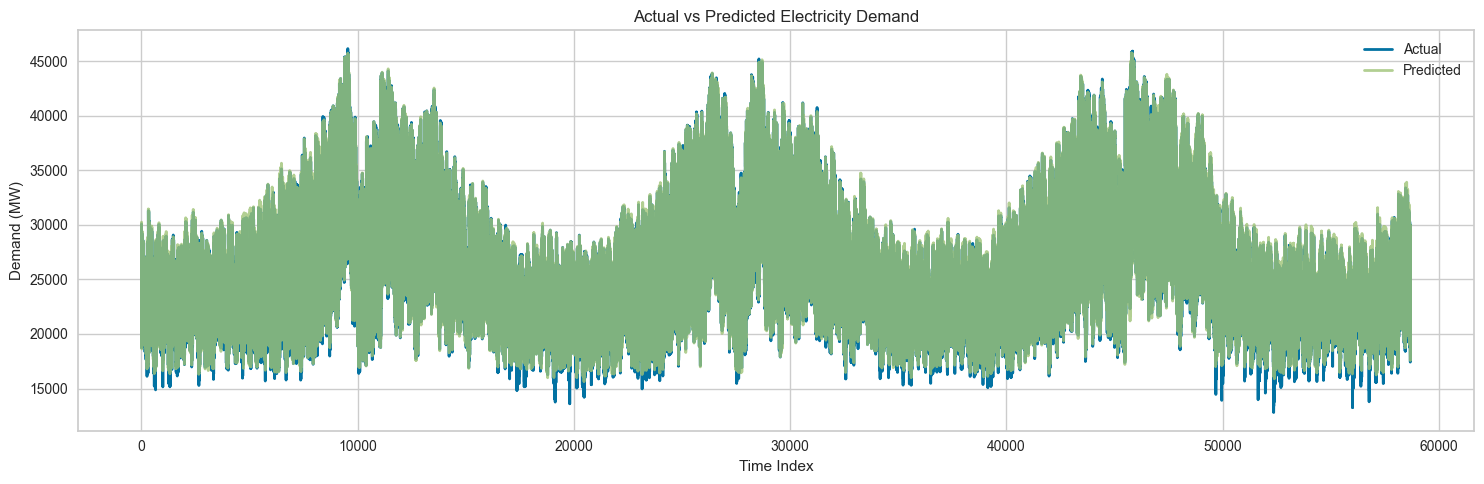

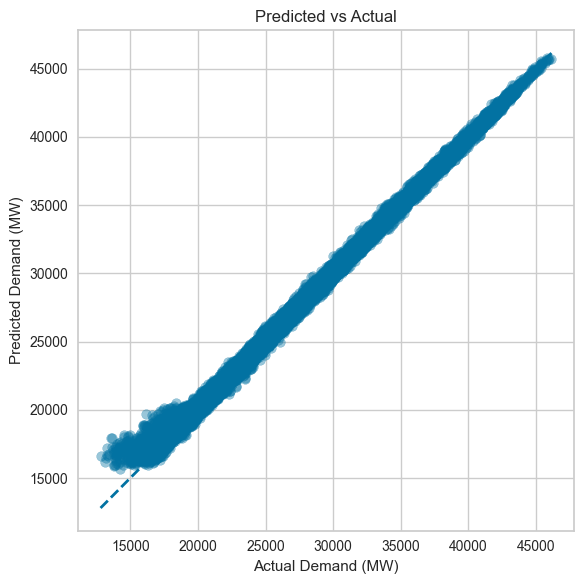

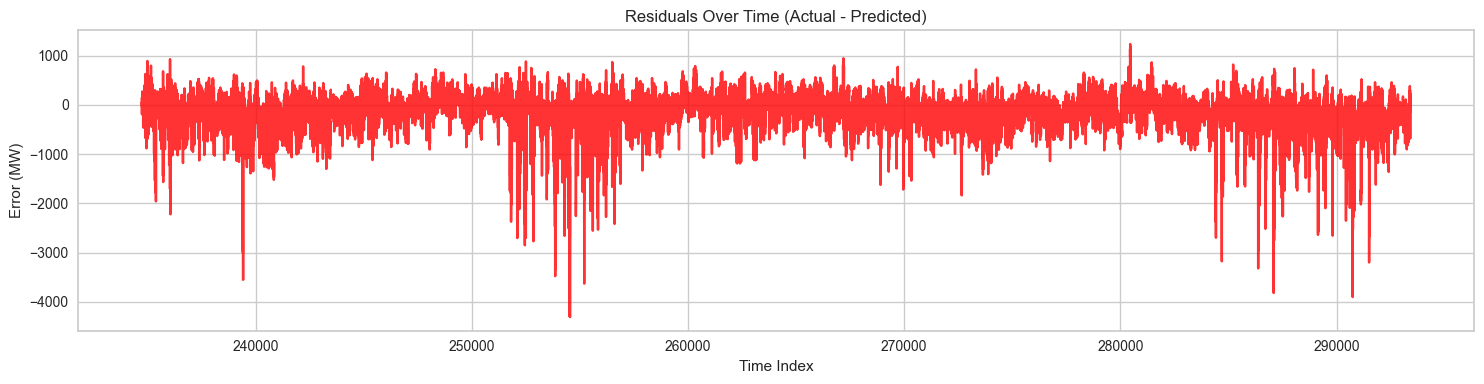

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Assume these already exist:
# model = trained LightGBM or ExtraTrees model
# X_test, y_test = your test set
# y_pred = model.predict(X_test)

# If needed:
model = lgb  # or etr
y_pred = model.predict(X_test)

# --- 1. LINE PLOT: Actual vs Predicted ---
plt.figure(figsize=(15, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2, alpha=0.8)
plt.title("Actual vs Predicted Electricity Demand")
plt.xlabel("Time Index")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. SCATTER PLOT: Predicted vs Actual ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
# Add ideal line
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', linewidth=2)
plt.title("Predicted vs Actual")
plt.xlabel("Actual Demand (MW)")
plt.ylabel("Predicted Demand (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. RESIDUAL PLOT (Errors) ---
residuals = y_test - y_pred

plt.figure(figsize=(15, 4))
plt.plot(residuals, color='red', alpha=0.8)
plt.title("Residuals Over Time (Actual - Predicted)")
plt.xlabel("Time Index")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()


Check for overfitting:

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Train predictions
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test predictions
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("TRAIN RMSE:", train_rmse)
print("TEST  RMSE:", test_rmse)
print("TRAIN MAE:", train_mae)
print("TEST  MAE:", test_mae)


TRAIN RMSE: 116.38539118600413
TEST  RMSE: 342.7011839120398
TRAIN MAE: 84.17614692959248
TEST  MAE: 235.28076464337698


In [27]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,

    # Prevent overfitting
    max_depth=6,          # shallower trees
    num_leaves=31,        # fewer leaves = less memorization
    min_child_samples=50, # require more data before splitting
    subsample=0.8,        # row sampling
    colsample_bytree=0.8, # feature sampling

    reg_alpha=0.1,        # L1 regularization
    reg_lambda=0.1,       # L2 regularization

    random_state=42
)

model.fit(X_train, y_train)
# Evaluate on test
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6353
[LightGBM] [Info] Number of data points in the train set: 234737, number of used features: 29
[LightGBM] [Info] Start training from score 32169.237619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [28]:
# Train predictions
y_train_pred = model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test predictions
y_test_pred = model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("TRAIN RMSE:", train_rmse)
print("TEST  RMSE:", test_rmse)
print("TRAIN MAE:", train_mae)
print("TEST  MAE:", test_mae)


TRAIN RMSE: 157.91771062895862
TEST  RMSE: 324.20642849916317
TRAIN MAE: 113.0209662314972
TEST  MAE: 234.15772460446382


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6353
[LightGBM] [Info] Number of data points in the train set: 234737, number of used features: 29
[LightGBM] [Info] Start training from score 32169.237619


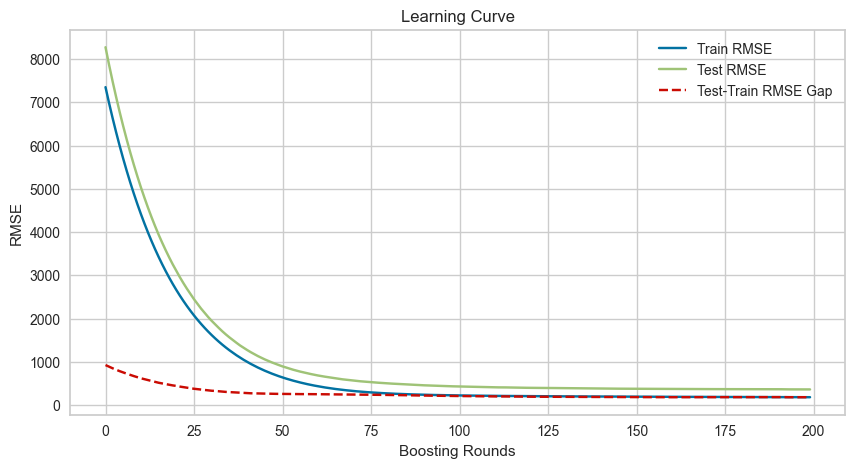

In [40]:
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)

# Get evaluation results
results = model.evals_result_

plt.figure(figsize=(10,5))
plt.plot(results['training']['rmse'], label='Train RMSE')
plt.plot(results['valid_1']['rmse'], label='Test RMSE')
plt.plot((np.array(results['valid_1']['rmse']) - np.array(results['training']['rmse'])), label='Test-Train RMSE Gap', linestyle='--')
plt.title("Learning Curve")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [-1, 5, 7, 9],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'n_estimators': [200, 400, 600, 800],
    'min_child_samples': [10, 20, 40, 80],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

model = LGBMRegressor(random_state=42)

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=40,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best Parameters:")
print(search.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6353
[LightGBM] [Info] Number of data points in the train set: 234737, number of used features: 29
[LightGBM] [Info] Start training from score 32169.237619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

LightGBM model using best parameters:

In [65]:
from lightgbm import LGBMRegressor

best_lgbm_model = LGBMRegressor(
    subsample=0.6,
    reg_lambda=0,
    reg_alpha=0.1,
    num_leaves=127,
    n_estimators=70,
    min_child_samples=40,
    max_depth=9,
    learning_rate=0.1,
    colsample_bytree=1.0,
    random_state=42
)
best_lgbm_model.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

preds = best_lgbm_model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Best LightGBM Model — Performance:")
print("MAE :", mae)
print("RMSE:", rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6353
[LightGBM] [Info] Number of data points in the train set: 234737, number of used features: 29
[LightGBM] [Info] Start training from score 32169.237619
Best LightGBM Model — Performance:
MAE : 248.5915776168961
RMSE: 352.6119608713896


In [66]:
# Train predictions
y_train_pred = best_lgbm_model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test predictions
y_test_pred = best_lgbm_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("TRAIN RMSE:", train_rmse)
print("TEST  RMSE:", test_rmse)
print("TRAIN MAE:", train_mae)
print("TEST  MAE:", test_mae)

TRAIN RMSE: 158.87606007344576
TEST  RMSE: 352.6119608713896
TRAIN MAE: 109.35621846819193
TEST  MAE: 248.5915776168961


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6353
[LightGBM] [Info] Number of data points in the train set: 234737, number of used features: 29
[LightGBM] [Info] Start training from score 32169.237619


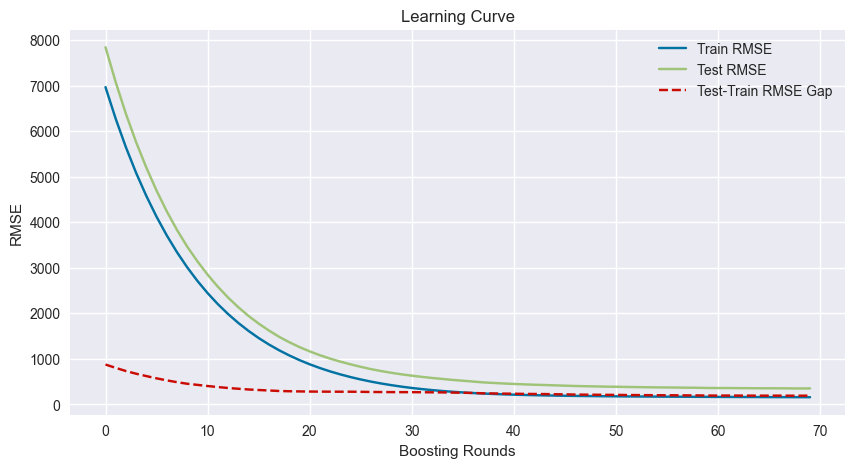

Final Train RMSE: 158.87606007344573
Final Test RMSE : 352.61196087138956
[6965.0393693804945, 6270.146832205014, 5644.872220168596, 5082.215124939699, 4575.981519705134, 4120.533102897732, 3710.753837724618, 3342.105392154409, 3010.4854264430546, 2712.2066467140294, 2443.94106066465, 2202.6910996956412, 1985.7825858844246, 1790.764071233662, 1615.5311022911023, 1458.108926679491, 1316.7059113201763, 1189.695935487809, 1075.6692198391413, 973.3242175012238, 881.5482092774312, 799.2451962413893, 725.6131693476976, 659.7427936460774, 600.9690126716963, 548.447442561078, 501.7365068731652, 460.15095635581343, 423.39432320055005, 390.82162272012596, 362.1031033442382, 336.81504956329997, 314.6760464458177, 295.300468275493, 278.34286193438777, 263.62038840622813, 250.84340010473792, 239.78859149981471, 230.30958131632568, 221.97660663915164, 214.80832958938828, 208.62479199133486, 203.3211934807828, 198.58666955101592, 194.5631095465937, 191.00589240409616, 187.8886240397223, 185.217384956

In [61]:
best_lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)

# Get evaluation results
results = best_lgbm_model.evals_result_

plt.figure(figsize=(10,5))
plt.plot(results['training']['rmse'], label='Train RMSE')
plt.plot(results['valid_1']['rmse'], label='Test RMSE')
plt.plot((np.array(results['valid_1']['rmse']) - np.array(results['training']['rmse'])), label='Test-Train RMSE Gap', linestyle='--')
plt.title("Learning Curve")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

# Check for overfitting:
train_rmse_final = results['training']['rmse'][-1]
test_rmse_final = results['valid_1']['rmse'][-1]
print("Final Train RMSE:", train_rmse_final)
print("Final Test RMSE :", test_rmse_final)

print(results['training']['rmse'])
print(results['valid_1']['rmse'])

Length used: 150
Min difference: 191.691029 at position 68
Max difference: 876.424162 at position 0
At min position -> train: 159.588450, valid: 351.279479
At max position -> train: 6965.039369, valid: 7841.463531


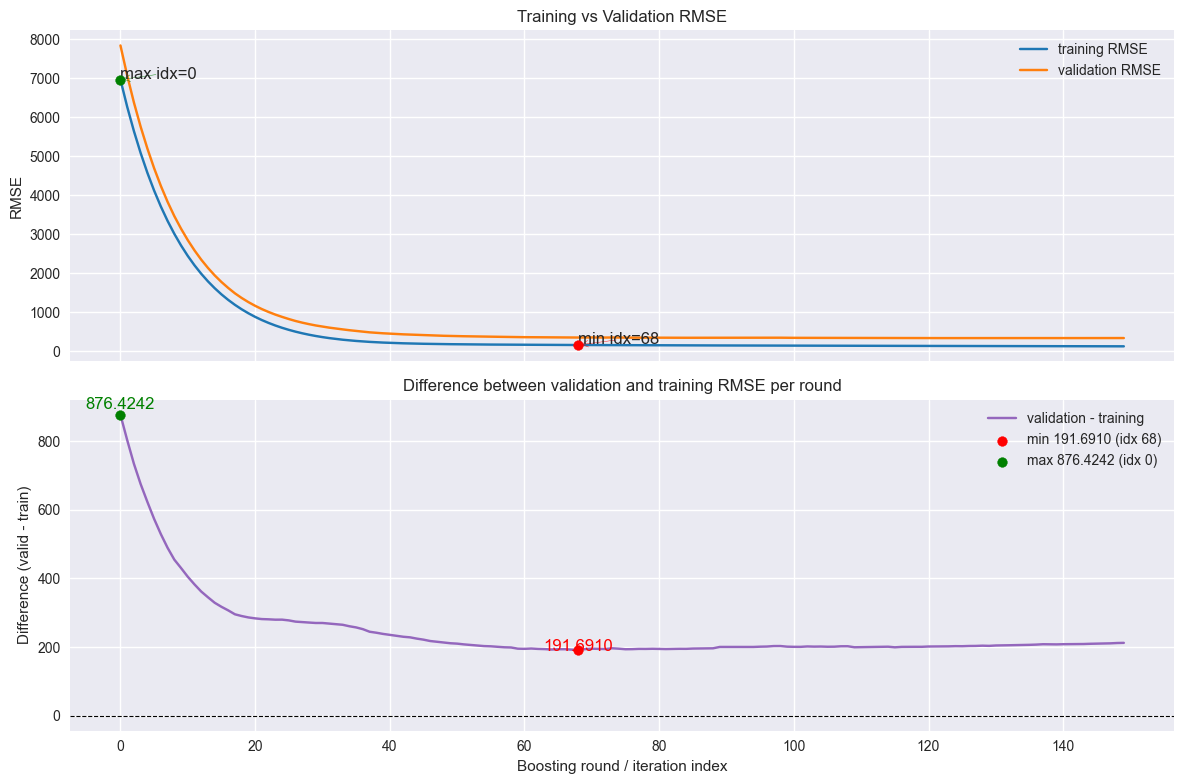

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Pull lists from results (ensure `results` exists)
train_list = list(results['training']['rmse'])
valid_list = list(results['valid_1']['rmse'])

# Truncate to the same length (use the overlapping portion)
n = min(len(train_list), len(valid_list))
if len(train_list) != len(valid_list):
    print(f"Warning: lists have different lengths (train={len(train_list)}, valid={len(valid_list)}). Truncating to {n}.")

train = np.array(train_list[:n])
valid = np.array(valid_list[:n])

# Element-wise difference (validation minus training)
diff = valid - train

# Find min and max and their positions
min_val = diff.min()
max_val = diff.max()
min_pos = int(diff.argmin())   # index of minimum
max_pos = int(diff.argmax())   # index of maximum

# Print summary
print(f"Length used: {n}")
print(f"Min difference: {min_val:.6f} at position {min_pos}")
print(f"Max difference: {max_val:.6f} at position {max_pos}")

# Optional: print the corresponding training/valid values
print(f"At min position -> train: {train[min_pos]:.6f}, valid: {valid[min_pos]:.6f}")
print(f"At max position -> train: {train[max_pos]:.6f}, valid: {valid[max_pos]:.6f}")

# Visualization
plt.style.use('seaborn-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: training and validation RMSE
ax1.plot(train, label='training RMSE', color='tab:blue')
ax1.plot(valid, label='validation RMSE', color='tab:orange')
ax1.set_ylabel('RMSE')
ax1.set_title('Training vs Validation RMSE')
ax1.legend()
ax1.grid(True)

# Mark the min/max indices on the top plot for context
ax1.scatter([min_pos], [train[min_pos]], color='red', zorder=5)
ax1.scatter([max_pos], [train[max_pos]], color='green', zorder=5)
ax1.annotate(f"min idx={min_pos}", (min_pos, train[min_pos]), xytext=(min_pos, train[min_pos] + 0.02*train.std()),
             arrowprops=dict(arrowstyle="->", color="red"))
ax1.annotate(f"max idx={max_pos}", (max_pos, train[max_pos]), xytext=(max_pos, train[max_pos] + 0.02*train.std()),
             arrowprops=dict(arrowstyle="->", color="green"))

# Bottom: difference
ax2.plot(diff, label='validation - training', color='tab:purple')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax2.scatter([min_pos], [min_val], color='red', zorder=6, label=f'min {min_val:.4f} (idx {min_pos})')
ax2.scatter([max_pos], [max_val], color='green', zorder=6, label=f'max {max_val:.4f} (idx {max_pos})')
ax2.set_ylabel('Difference (valid - train)')
ax2.set_xlabel('Boosting round / iteration index')
ax2.set_title('Difference between validation and training RMSE per round')
ax2.legend()
ax2.grid(True)

# Annotate exact values on the diff plot
ax2.annotate(f"{min_val:.4f}", xy=(min_pos, min_val), xytext=(min_pos, min_val - 0.02*abs(min_val)),
             ha='center', color='red')
ax2.annotate(f"{max_val:.4f}", xy=(max_pos, max_val), xytext=(max_pos, max_val + 0.02*abs(max_val)),
             ha='center', color='green')

plt.tight_layout()
plt.show()

### Feature engineering to reduce overfitting

In [67]:
#!pip install holidays

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 9.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
# 0. libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import holidays

# assume demand_df already loaded and settlement_date is datetime
df = demand_df.copy()
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df = df.sort_values('settlement_date').reset_index(drop=True)

# 1. Feature engineering (lags + rolling)
def make_features(df, lags=[1,48,336], rolls=[3,6,24,48, 168, 336]):
    df2 = df.copy()
    # time features
    df2['period'] = df2['settlement_period'].astype(int)
    df2['dayofweek'] = df2['settlement_date'].dt.dayofweek
    df2['month'] = df2['settlement_date'].dt.month
    df2['is_weekend'] = df2['dayofweek'].isin([5,6]).astype(int)
    #df2['year'] = df2['settlement_date'].dt.year
    
    uk_holidays = holidays.UnitedKingdom()
    df2['is_holiday'] = df2['settlement_date'].dt.date.apply(lambda x: x in uk_holidays).astype(int)

    # lag features
    for l in lags:
        df2[f'nd_lag_{l}'] = df2['nd'].shift(l)

    # rolling means/std
    for r in rolls:
        df2[f'nd_roll_mean_{r}'] = df2['nd'].shift(1).rolling(r).mean()
        df2[f'nd_roll_std_{r}']  = df2['nd'].shift(1).rolling(r).std()

    # fill or leave NaNs (we use drop for simplicity)
    return df2

df_feat = make_features(df)
df_feat = df_feat.dropna().reset_index(drop=True)  # keep only rows with complete features

# 2. Train/test split (time-aware)
train_frac = 0.8
n = len(df_feat)
train_idx = int(n * train_frac)
train = df_feat.iloc[:train_idx]
test  = df_feat.iloc[train_idx:]

# Select features and target
features = [c for c in df_feat.columns if c not in ['settlement_date', 'nd']]
target = 'nd'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [104]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Your best parameters
best_params = {
    'subsample': 0.6,
    'reg_lambda': 0,
    'reg_alpha': 0.1,
    'num_leaves': 127,
    'n_estimators': 150,
    'min_child_samples': 40,
    'max_depth': 6,
    'learning_rate': 0.1,
    'colsample_bytree': 1.0
}

# Model
model = LGBMRegressor(**best_params, random_state=42)

# Train
model.fit(X_train, y_train)

# Predict
train_preds = model.predict(X_train)
test_preds  = model.predict(X_test)

# Metrics
train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse  = mean_squared_error(y_test, test_preds, squared=False)

train_mae = mean_absolute_error(y_train, train_preds)
test_mae  = mean_absolute_error(y_test, test_preds)

print("---- LIGHTGBM WITH NEW FEATURES ----")
print("Train RMSE:", train_rmse)
print("Test  RMSE:", test_rmse)
print("Train MAE :", train_mae)
print("Test  MAE :", test_mae)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7426
[LightGBM] [Info] Number of data points in the train set: 234737, number of used features: 35
[LightGBM] [Info] Start training from score 32169.237619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7426
[LightGBM] [Info] Number of data points in the train set: 234737, number of used features: 35
[LightGBM] [Info] Start training from score 32169.237619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

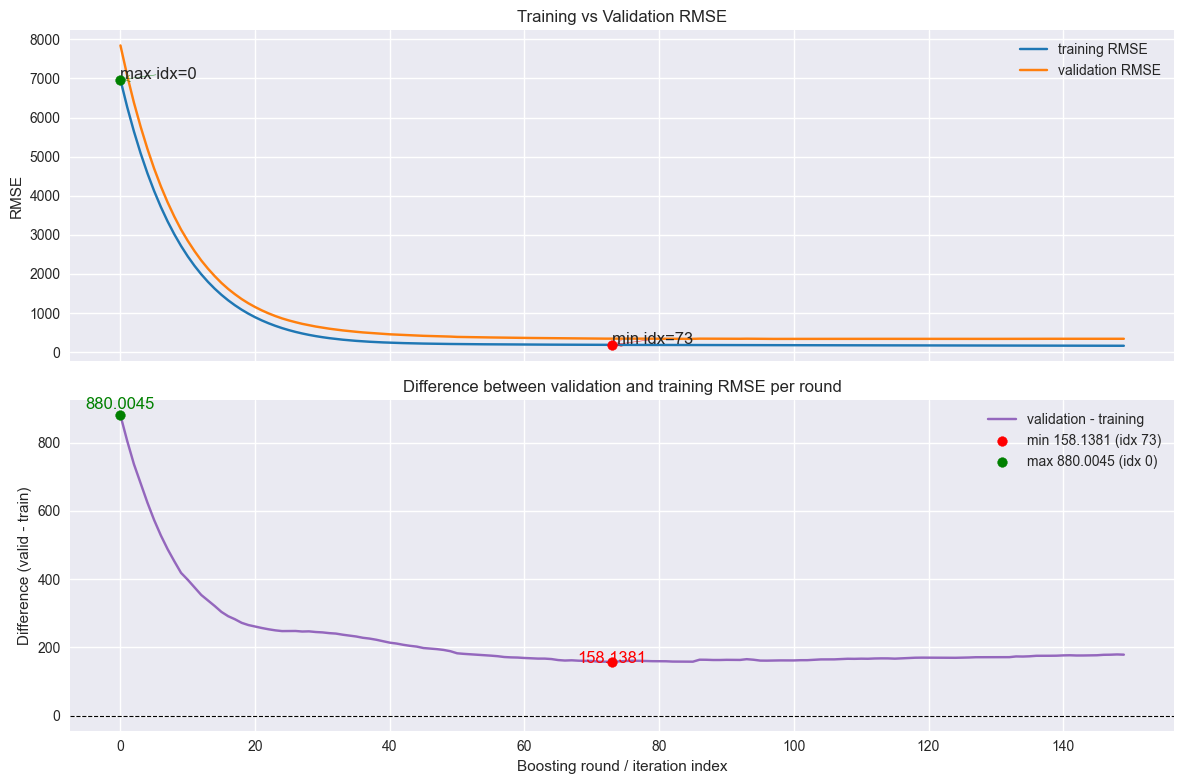

In [105]:
import numpy as np
import matplotlib.pyplot as plt

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)

# Get evaluation results
results = model.evals_result_

# Pull lists from results (ensure `results` exists)
train_list = list(results['training']['rmse'])
valid_list = list(results['valid_1']['rmse'])

# Truncate to the same length (use the overlapping portion)
n = min(len(train_list), len(valid_list))
if len(train_list) != len(valid_list):
    print(f"Warning: lists have different lengths (train={len(train_list)}, valid={len(valid_list)}). Truncating to {n}.")

train = np.array(train_list[:n])
valid = np.array(valid_list[:n])

# Element-wise difference (validation minus training)
diff = valid - train

# Find min and max and their positions
min_val = diff.min()
max_val = diff.max()
min_pos = int(diff.argmin())   # index of minimum
max_pos = int(diff.argmax())   # index of maximum

# Print summary
print(f"Length used: {n}")
print(f"Min difference: {min_val:.6f} at position {min_pos}")
print(f"Max difference: {max_val:.6f} at position {max_pos}")

# Optional: print the corresponding training/valid values
print(f"At min position -> train: {train[min_pos]:.6f}, valid: {valid[min_pos]:.6f}")
print(f"At max position -> train: {train[max_pos]:.6f}, valid: {valid[max_pos]:.6f}")

# Visualization
plt.style.use('seaborn-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: training and validation RMSE
ax1.plot(train, label='training RMSE', color='tab:blue')
ax1.plot(valid, label='validation RMSE', color='tab:orange')
ax1.set_ylabel('RMSE')
ax1.set_title('Training vs Validation RMSE')
ax1.legend()
ax1.grid(True)

# Mark the min/max indices on the top plot for context
ax1.scatter([min_pos], [train[min_pos]], color='red', zorder=5)
ax1.scatter([max_pos], [train[max_pos]], color='green', zorder=5)
ax1.annotate(f"min idx={min_pos}", (min_pos, train[min_pos]), xytext=(min_pos, train[min_pos] + 0.02*train.std()),
             arrowprops=dict(arrowstyle="->", color="red"))
ax1.annotate(f"max idx={max_pos}", (max_pos, train[max_pos]), xytext=(max_pos, train[max_pos] + 0.02*train.std()),
             arrowprops=dict(arrowstyle="->", color="green"))

# Bottom: difference
ax2.plot(diff, label='validation - training', color='tab:purple')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax2.scatter([min_pos], [min_val], color='red', zorder=6, label=f'min {min_val:.4f} (idx {min_pos})')
ax2.scatter([max_pos], [max_val], color='green', zorder=6, label=f'max {max_val:.4f} (idx {max_pos})')
ax2.set_ylabel('Difference (valid - train)')
ax2.set_xlabel('Boosting round / iteration index')
ax2.set_title('Difference between validation and training RMSE per round')
ax2.legend()
ax2.grid(True)

# Annotate exact values on the diff plot
ax2.annotate(f"{min_val:.4f}", xy=(min_pos, min_val), xytext=(min_pos, min_val - 0.02*abs(min_val)),
             ha='center', color='red')
ax2.annotate(f"{max_val:.4f}", xy=(max_pos, max_val), xytext=(max_pos, max_val + 0.02*abs(max_val)),
             ha='center', color='green')

plt.tight_layout()
plt.show()

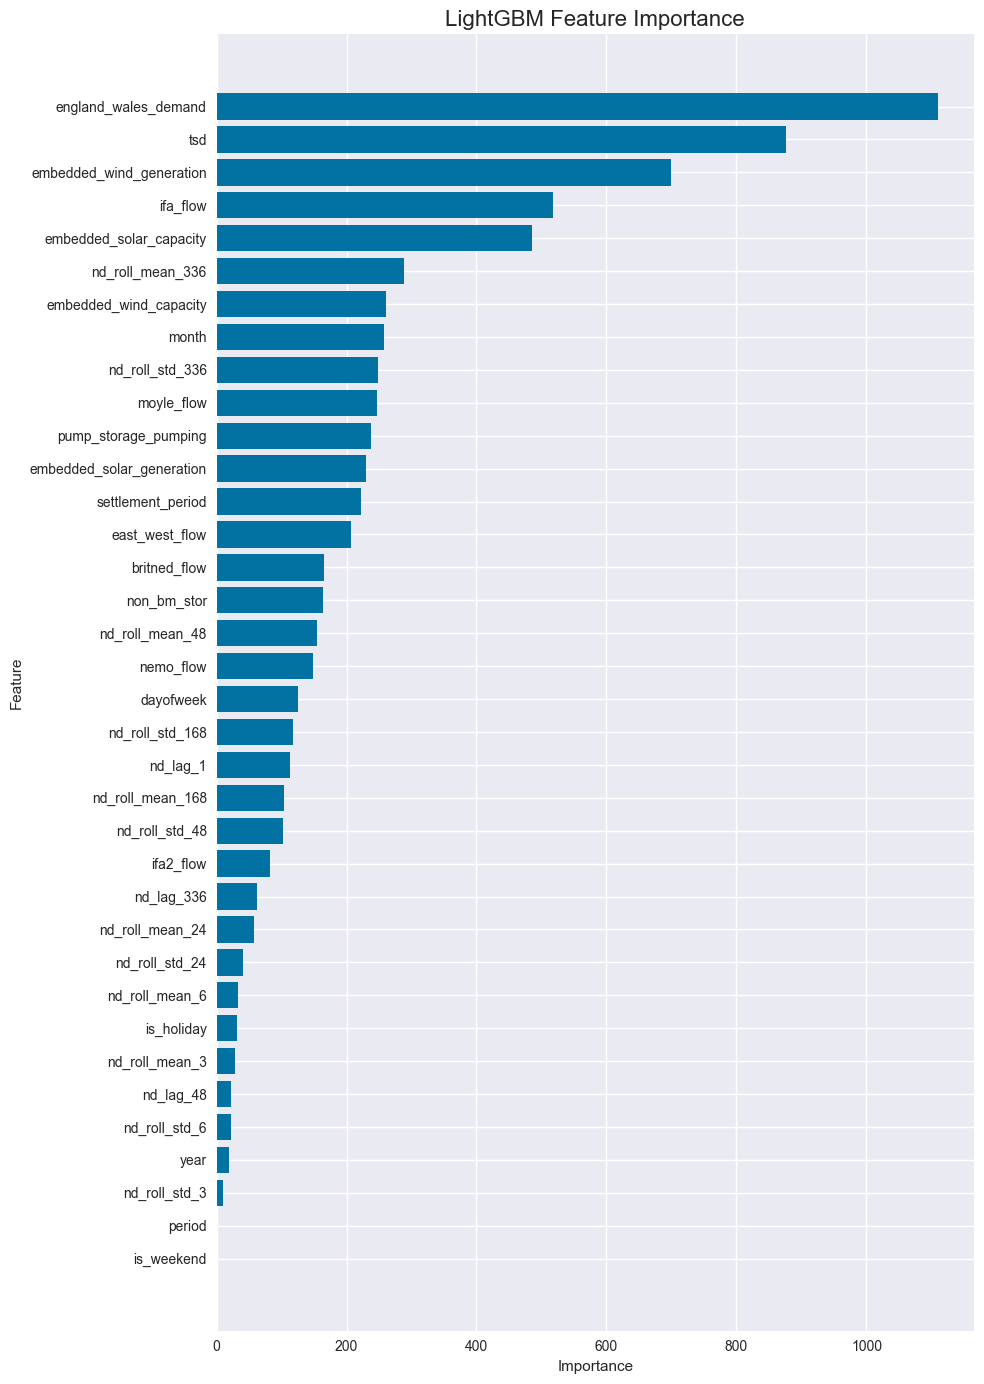

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importance values
importances = model.feature_importances_
feature_names = X_train.columns

# Put into a DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# Sort descending
fi_df = fi_df.sort_values("importance", ascending=True)

# Plot
plt.figure(figsize=(10, 14))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.title("LightGBM Feature Importance", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [99]:
uk_holidays = holidays.UnitedKingdom()
df_test = demand_df.copy()
df_test['settlement_date'] = pd.to_datetime(df_test['settlement_date'])
df_test['is_holiday'] = df_test['settlement_date'].dt.date.apply(lambda x: x in uk_holidays).astype(int)
print(uk_holidays)
df_test[df_test['is_holiday'] == 1][['settlement_date', 'is_holiday']].drop_duplicates().sort_values('settlement_date')

{datetime.date(2009, 4, 10): 'Good Friday', datetime.date(2009, 5, 4): 'May Day', datetime.date(2009, 5, 25): 'Spring Bank Holiday', datetime.date(2009, 1, 1): "New Year's Day", datetime.date(2009, 12, 25): 'Christmas Day', datetime.date(2009, 12, 26): 'Boxing Day', datetime.date(2009, 12, 28): 'Boxing Day (observed)', datetime.date(2010, 4, 2): 'Good Friday', datetime.date(2010, 5, 3): 'May Day', datetime.date(2010, 5, 31): 'Spring Bank Holiday', datetime.date(2010, 1, 1): "New Year's Day", datetime.date(2010, 12, 25): 'Christmas Day', datetime.date(2010, 12, 27): 'Christmas Day (observed)', datetime.date(2010, 12, 26): 'Boxing Day', datetime.date(2010, 12, 28): 'Boxing Day (observed)', datetime.date(2011, 4, 22): 'Good Friday', datetime.date(2011, 5, 2): 'May Day', datetime.date(2011, 5, 30): 'Spring Bank Holiday', datetime.date(2011, 4, 29): 'Wedding of William and Catherine', datetime.date(2011, 1, 1): "New Year's Day", datetime.date(2011, 1, 3): "New Year's Day (observed)", dateti

,settlement_date,is_holiday
0,2009-01-01,1
4750,2009-04-10,1
5902,2009-05-04,1
6910,2009-05-25,1
17184,2009-12-25,1
...,...,...
280224,2024-12-26,1
280512,2025-01-01,1
285646,2025-04-18,1
286462,2025-05-05,1


## Extra trees finding best parameters

In [85]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


ExtraTreesRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                    min_samples_split=10, n_estimators=200, n_jobs=-1,
                    random_state=42)

In [86]:
# Train predictions
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test predictions
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("TRAIN RMSE:", train_rmse)
print("TEST  RMSE:", test_rmse)
print("TRAIN MAE:", train_mae)
print("TEST  MAE:", test_mae)


TRAIN RMSE: 469.5245482173687
TEST  RMSE: 773.3238976746726
TRAIN MAE: 352.7821921787955
TEST  MAE: 582.0905659052855
